# 🏥 Retinal Disease Dataset - Exploratory Data Analysis
## RFMiD Dataset: Multi-Label Disease Classification

**Objective:** Comprehensive analysis of retinal fundus images for 45 disease classes

**Dataset:** RFMiD (Retinal Fundus Multi-Disease Dataset)
- Training: 1,920 images
- Validation: 640 images
- Testing: 640 images
- Total: 3,200 images
- Classes: 45 retinal diseases

## 1. Import Libraries and Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.metrics import confusion_matrix

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.2.6


## 2. Load Dataset

In [2]:
# Define base path
base_path = Path("/home/darkhorse/Downloads/Compressed/Multi Rentinal Disease Model/A. RFMiD_All_Classes_Dataset")

# Load label files
train_labels = pd.read_csv(base_path / "2. Groundtruths/a. RFMiD_Training_Labels.csv")
val_labels = pd.read_csv(base_path / "2. Groundtruths/b. RFMiD_Validation_Labels.csv")
test_labels = pd.read_csv(base_path / "2. Groundtruths/c. RFMiD_Testing_Labels.csv")

# Add split identifier
train_labels['split'] = 'train'
val_labels['split'] = 'val'
test_labels['split'] = 'test'

# Combine all
all_labels = pd.concat([train_labels, val_labels, test_labels], ignore_index=True)

print("✓ Dataset loaded successfully!")
print(f"\nTraining samples: {len(train_labels):,}")
print(f"Validation samples: {len(val_labels):,}")
print(f"Testing samples: {len(test_labels):,}")
print(f"Total samples: {len(all_labels):,}")
print(f"\nFeatures: {train_labels.shape[1]}")

✓ Dataset loaded successfully!

Training samples: 1,920
Validation samples: 640
Testing samples: 640
Total samples: 3,200

Features: 48


In [3]:
# Display first few rows and identify disease columns
print("First 5 samples from training set:")
display(train_labels.head())

# Get disease columns (all columns except ID, Disease_Risk, and split)
disease_columns = [col for col in train_labels.columns if col not in ['ID', 'Disease_Risk', 'split']]

print(f"\n✓ Identified {len(disease_columns)} disease columns")
print(f"Disease columns: {disease_columns[:5]}... (showing first 5)")

First 5 samples from training set:


,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,split
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,train



✓ Identified 45 disease columns
Disease columns: ['DR', 'ARMD', 'MH', 'DN', 'MYA']... (showing first 5)


In [4]:
# Calculate key metrics needed for analysis
# These will be used throughout the notebook
disease_counts = train_labels[disease_columns].sum().sort_values(ascending=False)
labels_per_sample = train_labels[disease_columns].sum(axis=1)

print(f"\n✓ Calculated disease statistics")
print(f"  - Most common disease: {disease_counts.index[0]} ({disease_counts.iloc[0]} cases)")
print(f"  - Least common disease: {disease_counts.index[-1]} ({disease_counts.iloc[-1]} cases)")
print(f"  - Average labels per sample: {labels_per_sample.mean():.2f}")


✓ Calculated disease statistics
  - Most common disease: DR (376 cases)
  - Least common disease: HR (0 cases)
  - Average labels per sample: 1.08


## 2.1 Data Quality Assessment - Missing Values & Duplicates

In [ ]:
# Step 4: Handling Duplicates
print("="*80)
print("STEP 4: DUPLICATE DETECTION & REMOVAL")
print("="*80)

# Ensure train_labels is defined
if 'train_labels' not in globals():
    raise NameError("The variable 'train_labels' is not defined. Please execute the cell that defines it.")

# Check for duplicate rows in training set
duplicates_count = train_labels.duplicated().sum()
print(f"\nDuplicate rows in training set: {duplicates_count}")

# Check for duplicate IDs
duplicate_ids = train_labels['ID'].duplicated().sum()
print(f"Duplicate image IDs: {duplicate_ids}")

if duplicates_count > 0:
    print(f"\n Found {duplicates_count} duplicate rows")
    # Remove duplicates if any
    train_labels_clean = train_labels.drop_duplicates()
    print(f" Removed duplicates. New shape: {train_labels_clean.shape}")
else:
    print("\n No duplicate rows found")
    train_labels_clean = train_labels

# Verify data types
print("\n" + "="*80)
print("DATA TYPES")
print("="*80)
print(train_labels_clean.dtypes)

# Check for missing values
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_summary = train_labels_clean.isnull().sum()
missing_percent = (missing_summary / len(train_labels_clean)) * 100

if missing_summary.sum() == 0:
    print(" No missing values detected in any column")
else:
    print("\nColumns with missing values:")
    for col, count in missing_summary[missing_summary > 0].items():
        print(f"  {col}: {count} ({missing_percent[col]:.2f}%)")

STEP 4: DUPLICATE DETECTION & REMOVAL

Duplicate rows in training set: 0
Duplicate image IDs: 0

✓ No duplicate rows found

DATA TYPES
ID               int64
Disease_Risk     int64
DR               int64
ARMD             int64
MH               int64
DN               int64
MYA              int64
BRVO             int64
TSLN             int64
ERM              int64
LS               int64
MS               int64
CSR              int64
ODC              int64
CRVO             int64
TV               int64
AH               int64
ODP              int64
ODE              int64
ST               int64
AION             int64
PT               int64
RT               int64
RS               int64
CRS              int64
EDN              int64
RPEC             int64
MHL              int64
RP               int64
CWS              int64
CB               int64
ODPM             int64
PRH              int64
MNF              int64
HR               int64
CRAO             int64
TD               int64
CME           

## 2.2 Type Conversion & Data Formatting (Step 5)

In [ ]:
# Step 5: Type Conversion & Data Formatting
print("="*80)
print("STEP 5: TYPE CONVERSION & DATA FORMATTING")
print("="*80)

# Store memory usage before conversion
memory_before = train_labels_clean.memory_usage(deep=True).sum() / 1024


# Convert Disease_Risk to category (0 or 1 representing risk levels)
train_labels_clean['Disease_Risk'] = train_labels_clean['Disease_Risk'].astype('category')

# Convert split to category (train/val/test)
train_labels_clean['split'] = train_labels_clean['split'].astype('category')

# Ensure disease columns remain as int8 for efficient storage while allowing math operations
for col in disease_columns:
    train_labels_clean[col] = train_labels_clean[col].astype('int8')

memory_after = train_labels_clean.memory_usage(deep=True).sum() / 1024

print("\n Converted categorical columns to category dtype")
print(" Converted disease columns to int8 (memory efficient, supports math operations)")
print(f"\nMemory usage before: {memory_before:.2f} KB")
print(f"Memory usage after: {memory_after:.2f} KB")
print(f"Memory reduction: {((memory_before - memory_after) / memory_before * 100):.1f}%")

# Validate binary labels
print("\n" + "="*80)
print("LABEL VALIDATION")
print("="*80)

invalid_labels = 0
for col in disease_columns:
    unique_vals = train_labels_clean[col].unique()
    if not set(unique_vals).issubset({0, 1}):
        print(f"  Column {col} has invalid values: {unique_vals}")
        invalid_labels += 1

if invalid_labels == 0:
    print(" All disease labels are properly formatted (binary: 0 or 1)")

# Show data types after conversion
print("\n" + "="*80)
print("DATA TYPES AFTER CONVERSION")
print("="*80)
print(f"Disease columns: {train_labels_clean[disease_columns[0]].dtype}")
print(f"Disease_Risk: {train_labels_clean['Disease_Risk'].dtype}")
print(f"split: {train_labels_clean['split'].dtype}")
    
print(f"\n Data formatting complete. Dataset is clean and ready for analysis.")

STEP 5: TYPE CONVERSION & DATA FORMATTING

✓ Converted categorical columns to category dtype
✓ Converted disease columns to int8 (memory efficient, supports math operations)

Memory usage before: 806.38 KB
Memory usage after: 103.53 KB
Memory reduction: 87.2%

LABEL VALIDATION
✓ All disease labels are properly formatted (binary: 0 or 1)

DATA TYPES AFTER CONVERSION
Disease columns: int8
Disease_Risk: category
split: category

✓ Data formatting complete. Dataset is clean and ready for analysis.


In [8]:
# Recalculate metrics with cleaned data
# Update disease_counts and labels_per_sample to use train_labels_clean
disease_counts = train_labels_clean[disease_columns].sum().sort_values(ascending=False)
labels_per_sample = train_labels_clean[disease_columns].sum(axis=1)

print("="*80)
print("UPDATED STATISTICS WITH CLEANED DATA")
print("="*80)
print(f"  - Most common disease: {disease_counts.index[0]} ({disease_counts.iloc[0]} cases)")
print(f"  - Least common disease: {disease_counts.index[-1]} ({disease_counts.iloc[-1]} cases)")
print(f"  - Average labels per sample: {labels_per_sample.mean():.2f}")

# Replace train_labels with cleaned version for all subsequent analysis
train_labels = train_labels_clean.copy()

print(f"\n✓ All subsequent analysis will use the cleaned dataset")
print(f"✓ train_labels now refers to the cleaned data ({len(train_labels)} samples)")

UPDATED STATISTICS WITH CLEANED DATA
  - Most common disease: DR (376 cases)
  - Least common disease: HR (0 cases)
  - Average labels per sample: 1.08

✓ All subsequent analysis will use the cleaned dataset
✓ train_labels now refers to the cleaned data (1920 samples)


## 3. Dataset Overview and Disease Statistics

In [9]:
# Display all disease classes
print(f"Number of disease classes: {len(disease_columns)}")
print(f"\nDisease classes:")
for i, disease in enumerate(disease_columns, 1):
    print(f"{i:2d}. {disease}")

Number of disease classes: 45

Disease classes:
 1. DR
 2. ARMD
 3. MH
 4. DN
 5. MYA
 6. BRVO
 7. TSLN
 8. ERM
 9. LS
10. MS
11. CSR
12. ODC
13. CRVO
14. TV
15. AH
16. ODP
17. ODE
18. ST
19. AION
20. PT
21. RT
22. RS
23. CRS
24. EDN
25. RPEC
26. MHL
27. RP
28. CWS
29. CB
30. ODPM
31. PRH
32. MNF
33. HR
34. CRAO
35. TD
36. CME
37. PTCR
38. CF
39. VH
40. MCA
41. VS
42. BRAO
43. PLQ
44. HPED
45. CL


In [10]:
# Disease prevalence in training set (using cleaned data)
print("="*80)
print("TOP 20 MOST COMMON DISEASES (Training Set)")
print("="*80)
print(f"{'Rank':<6} {'Code':<10} {'Count':<10} {'Prevalence'}")
print("-"*80)

for rank, (disease, count) in enumerate(disease_counts.head(20).items(), 1):
    percentage = (count / len(train_labels_clean)) * 100
    print(f"{rank:<6} {disease:<10} {count:<10} {percentage:5.2f}%")

TOP 20 MOST COMMON DISEASES (Training Set)
Rank   Code       Count      Prevalence
--------------------------------------------------------------------------------
1      DR         376        19.58%
2      MH         317        16.51%
3      ODC        282        14.69%
4      TSLN       186         9.69%
5      DN         138         7.19%
6      MYA        101         5.26%
7      ARMD       100         5.21%
8      BRVO       73          3.80%
9      ODP        65          3.39%
10     ODE        58          3.02%
11     LS         47          2.45%
12     RS         43          2.24%
13     CSR        37          1.93%
14     CRS        32          1.67%
15     CRVO       28          1.46%
16     RPEC       22          1.15%
17     AION       17          0.89%
18     AH         16          0.83%
19     MS         15          0.78%
20     EDN        15          0.78%


In [11]:
# Multi-label statistics (using cleaned data)
print("="*60)
print("MULTI-LABEL STATISTICS")
print("="*60)
print(f"Min labels per sample: {labels_per_sample.min()}")
print(f"Max labels per sample: {labels_per_sample.max()}")
print(f"Mean labels per sample: {labels_per_sample.mean():.2f}")
print(f"Median labels per sample: {labels_per_sample.median():.1f}")
print(f"Std labels per sample: {labels_per_sample.std():.2f}")

print(f"\nLabel distribution:")
print(labels_per_sample.value_counts().sort_index())

MULTI-LABEL STATISTICS
Min labels per sample: 0
Max labels per sample: 5
Mean labels per sample: 1.08
Median labels per sample: 1.0
Std labels per sample: 0.77

Label distribution:
0     401
1    1061
2     373
3      79
4       5
5       1
Name: count, dtype: int64


## 3.1 Univariate Analysis - Numerical Variables (Step 6)

In [ ]:
# Step 6: Analyzing Numerical Variables - Distribution Analysis
print("="*80)
print("STEP 6: UNIVARIATE ANALYSIS - NUMERICAL VARIABLES")
print("="*80)

# Analyze labels per sample (numerical feature)
print("\nDistribution Statistics for 'Labels per Sample':")
print(f"  Mean:     {labels_per_sample.mean():.3f}")
print(f"  Median:   {labels_per_sample.median():.1f}")
print(f"  Mode:     {labels_per_sample.mode()[0]}")
print(f"  Std Dev:  {labels_per_sample.std():.3f}")
print(f"  Variance: {labels_per_sample.var():.3f}")
print(f"  Skewness: {labels_per_sample.skew():.3f}")
print(f"  Kurtosis: {labels_per_sample.kurtosis():.3f}")

# Quartiles and IQR
Q1 = labels_per_sample.quantile(0.25)
Q2 = labels_per_sample.quantile(0.50)
Q3 = labels_per_sample.quantile(0.75)
IQR = Q3 - Q1

print(f"\nQuartiles:")
print(f"  Q1 (25%): {Q1:.1f}")
print(f"  Q2 (50%): {Q2:.1f}")
print(f"  Q3 (75%): {Q3:.1f}")
print(f"  IQR:      {IQR:.1f}")

# Create comprehensive univariate visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Histogram with KDE
ax1 = axes[0, 0]
ax1.hist(labels_per_sample, bins=range(0, labels_per_sample.max()+2), 
         color='skyblue', edgecolor='black', alpha=0.7, density=True, label='Frequency')
labels_per_sample.plot(kind='kde', ax=ax1, color='red', linewidth=2, label='KDE')
ax1.axvline(labels_per_sample.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {labels_per_sample.mean():.2f}')
ax1.axvline(labels_per_sample.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {labels_per_sample.median():.1f}')
ax1.set_xlabel('Number of Diseases per Sample', fontsize=11, fontweight='bold')
ax1.set_ylabel('Density', fontsize=11, fontweight='bold')
ax1.set_title('Histogram + KDE: Distribution of Labels per Sample', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Box Plot
ax2 = axes[0, 1]
box = ax2.boxplot(labels_per_sample, vert=True, patch_artist=True,
                  boxprops=dict(facecolor='lightcoral', alpha=0.7),
                  medianprops=dict(color='darkred', linewidth=2),
                  whiskerprops=dict(color='black', linewidth=1.5),
                  capprops=dict(color='black', linewidth=1.5))
ax2.set_ylabel('Number of Diseases', fontsize=11, fontweight='bold')
ax2.set_title('Box Plot: Labels per Sample (Outlier Detection)', fontsize=12, fontweight='bold')
ax2.set_xticklabels(['Labels per Sample'])
ax2.grid(axis='y', alpha=0.3)

# Add statistics to box plot
stats_text = f"Median: {Q2:.1f}\nQ1: {Q1:.1f}\nQ3: {Q3:.1f}\nIQR: {IQR:.1f}"
ax2.text(1.15, labels_per_sample.median(), stats_text, fontsize=9, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Value Counts Bar Chart
ax3 = axes[1, 0]
value_counts = labels_per_sample.value_counts().sort_index()
ax3.bar(value_counts.index, value_counts.values, color='teal', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Number of Diseases', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Frequency Distribution of Multi-Label Counts', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add percentage labels
for x, y in zip(value_counts.index, value_counts.values):
    percentage = (y / len(train_labels)) * 100
    ax3.text(x, y + 10, f'{percentage:.1f}%', ha='center', fontsize=8)

# 4. Cumulative Distribution
ax4 = axes[1, 1]
sorted_data = np.sort(labels_per_sample)
cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax4.plot(sorted_data, cumulative, color='purple', linewidth=2)
ax4.axhline(y=0.5, color='red', linestyle='--', label='50th Percentile')
ax4.axhline(y=0.75, color='orange', linestyle='--', label='75th Percentile')
ax4.set_xlabel('Number of Diseases per Sample', fontsize=11, fontweight='bold')
ax4.set_ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
ax4.set_title('Cumulative Distribution Function (CDF)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('EDA_Univariate_Numerical.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: EDA_Univariate_Numerical.png")
plt.show()

## 3.2 Univariate Analysis - Categorical Variables (Step 7)

STEP 7: UNIVARIATE ANALYSIS - CATEGORICAL VARIABLES

Disease Risk Distribution:
  Risk Level 1: 1,519 samples (79.11%)
  Risk Level 0: 401 samples (20.89%)

--------------------------------------------------------------------------------
DISEASE PREVALENCE CATEGORIZATION
--------------------------------------------------------------------------------
Very Common (>10%):    3 diseases
Common (5-10%):        4 diseases
Uncommon (1-5%):       9 diseases
Rare (<1%):            29 diseases

--------------------------------------------------------------------------------
TOP 10 DISEASES - FREQUENCY ANALYSIS
--------------------------------------------------------------------------------
 1. DR      :  376 cases (19.58%)
 2. MH      :  317 cases (16.51%)
 3. ODC     :  282 cases (14.69%)
 4. TSLN    :  186 cases ( 9.69%)
 5. DN      :  138 cases ( 7.19%)
 6. MYA     :  101 cases ( 5.26%)
 7. ARMD    :  100 cases ( 5.21%)
 8. BRVO    :   73 cases ( 3.80%)
 9. ODP     :   65 cases ( 3.39%)
10. 

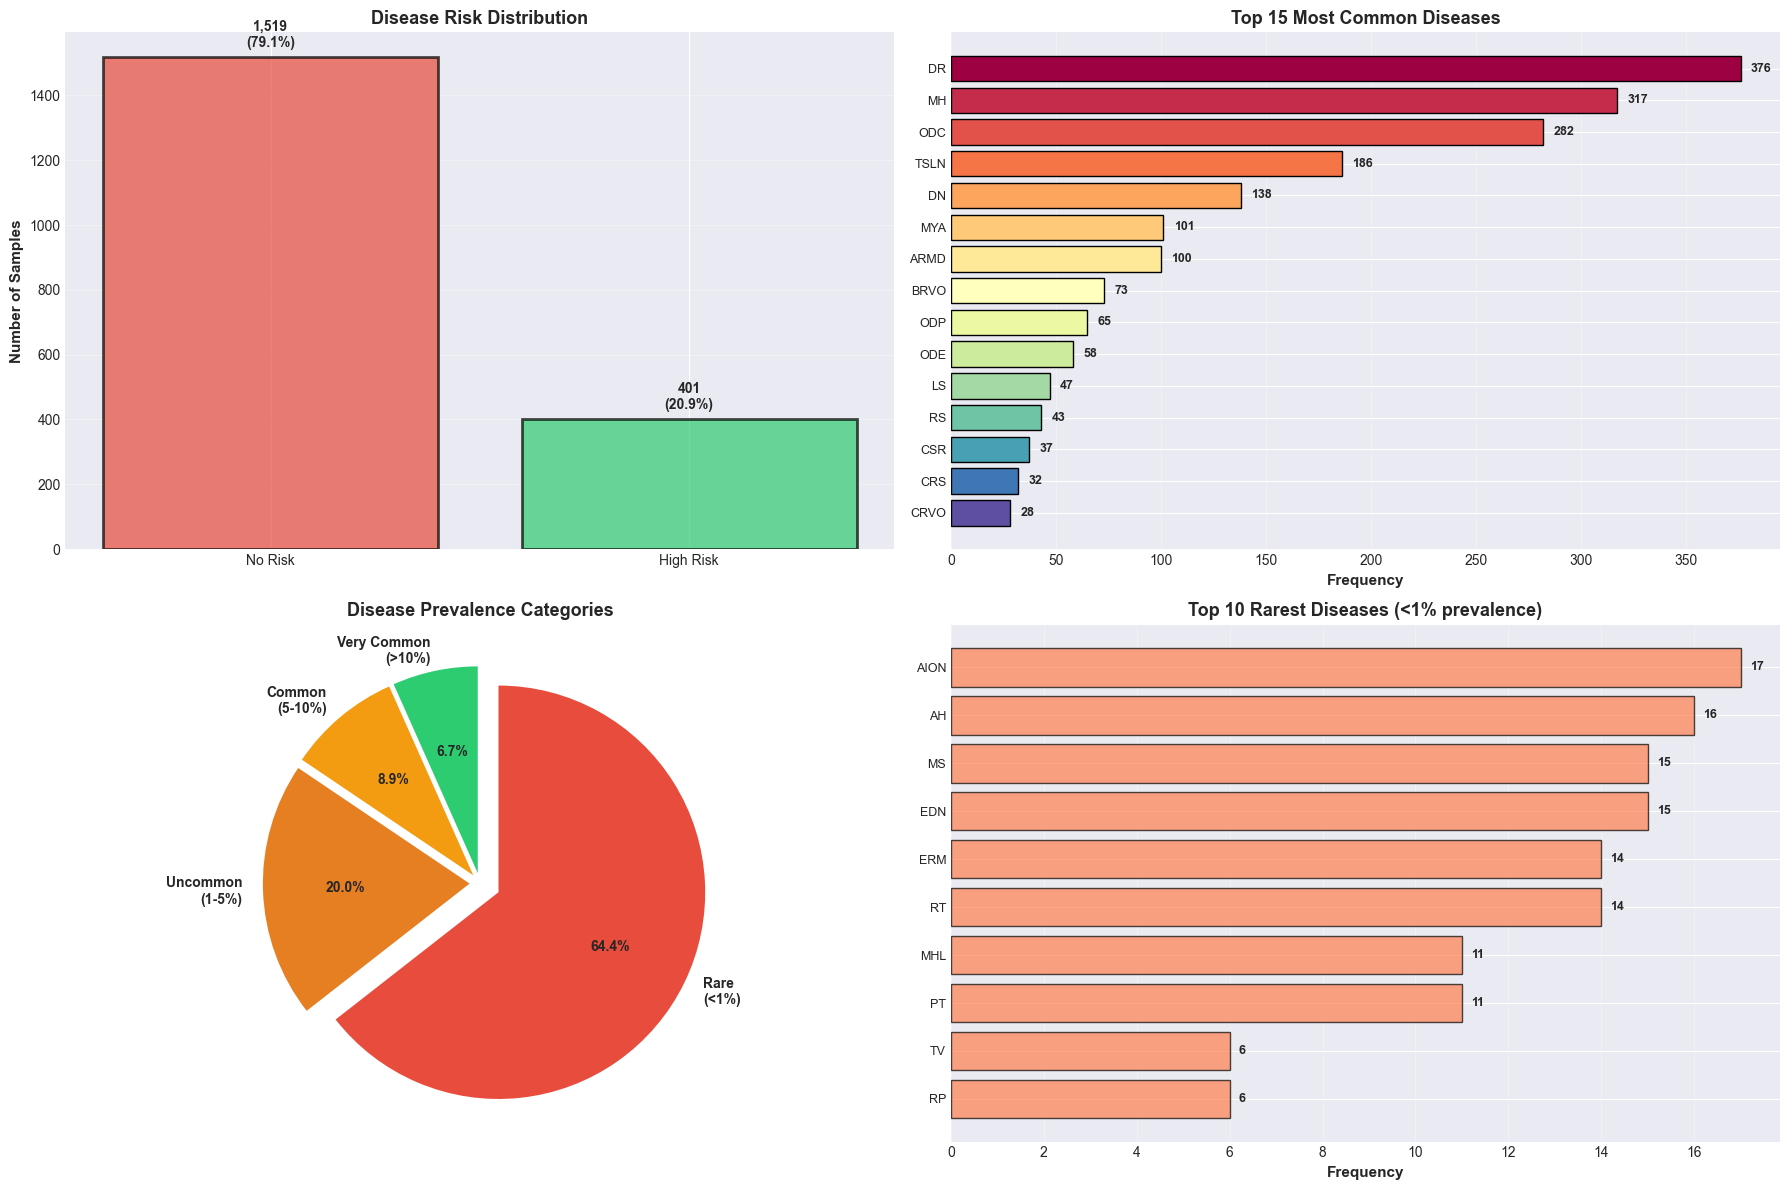


✓ Univariate analysis (categorical variables) complete


In [13]:
# Step 7: Analyzing Categorical Variables
print("="*80)
print("STEP 7: UNIVARIATE ANALYSIS - CATEGORICAL VARIABLES")
print("="*80)

# Analyze Disease_Risk (binary categorical)
print("\nDisease Risk Distribution:")
risk_counts = train_labels['Disease_Risk'].value_counts()
risk_percentages = (risk_counts / len(train_labels)) * 100

for risk, count in risk_counts.items():
    print(f"  Risk Level {risk}: {count:,} samples ({risk_percentages[risk]:.2f}%)")

# Categorize diseases by prevalence
print("\n" + "-"*80)
print("DISEASE PREVALENCE CATEGORIZATION")
print("-"*80)

# Define prevalence categories based on percentage
total_samples = len(train_labels)
disease_percentages = (disease_counts / total_samples) * 100

very_common_diseases = disease_counts[disease_percentages > 10]
common_diseases = disease_counts[(disease_percentages >= 5) & (disease_percentages <= 10)]
uncommon_diseases = disease_counts[(disease_percentages >= 1) & (disease_percentages < 5)]
rare_diseases = disease_counts[disease_percentages < 1]

print(f"Very Common (>10%):    {len(very_common_diseases)} diseases")
print(f"Common (5-10%):        {len(common_diseases)} diseases")
print(f"Uncommon (1-5%):       {len(uncommon_diseases)} diseases")
print(f"Rare (<1%):            {len(rare_diseases)} diseases")

# Analyze top diseases as categorical variables
print("\n" + "-"*80)
print("TOP 10 DISEASES - FREQUENCY ANALYSIS")
print("-"*80)

top_10_diseases = disease_counts.head(10)
for rank, (disease, count) in enumerate(top_10_diseases.items(), 1):
    percentage = (count / len(train_labels)) * 100
    print(f"{rank:2d}. {disease:8s}: {count:4d} cases ({percentage:5.2f}%)")

# Create categorical visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Disease Risk Distribution - Bar Chart
ax1 = axes[0, 0]
colors_risk = ['#2ecc71' if r == 0 else '#e74c3c' for r in risk_counts.index]
bars = ax1.bar(['No Risk', 'High Risk'], risk_counts.values, color=colors_risk, 
               edgecolor='black', linewidth=2, alpha=0.7)
ax1.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax1.set_title('Disease Risk Distribution', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value and percentage labels
for i, (bar, count) in enumerate(zip(bars, risk_counts.values)):
    percentage = (count / len(train_labels)) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., count + 30, 
             f'{count:,}\n({percentage:.1f}%)', ha='center', fontsize=10, fontweight='bold')

# 2. Top 15 Diseases - Horizontal Bar Chart
ax2 = axes[0, 1]
top_15 = disease_counts.head(15)
colors_gradient = plt.cm.Spectral(np.linspace(0, 1, len(top_15)))
bars = ax2.barh(range(len(top_15)), top_15.values, color=colors_gradient, edgecolor='black')
ax2.set_yticks(range(len(top_15)))
ax2.set_yticklabels(top_15.index, fontsize=9)
ax2.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Top 15 Most Common Diseases', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Add frequency labels
for i, (bar, count) in enumerate(zip(bars, top_15.values)):
    ax2.text(count + 5, i, str(count), va='center', fontsize=9, fontweight='bold')

# 3. Disease Prevalence Categories - Pie Chart
ax3 = axes[1, 0]
category_counts = [
    len(very_common_diseases),
    len(common_diseases),
    len(uncommon_diseases),
    len(rare_diseases)
]
categories = ['Very Common\n(>10%)', 'Common\n(5-10%)', 'Uncommon\n(1-5%)', 'Rare\n(<1%)']
colors_pie = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
explode = (0.05, 0.05, 0.05, 0.1)

wedges, texts, autotexts = ax3.pie(category_counts, labels=categories, autopct='%1.1f%%',
                                     colors=colors_pie, explode=explode, startangle=90,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('Disease Prevalence Categories', fontsize=13, fontweight='bold')

# 4. Rare Diseases Analysis - Bar Chart
ax4 = axes[1, 1]
rare_disease_list = rare_diseases.head(10)  # Top 10 rarest
ax4.barh(range(len(rare_disease_list)), rare_disease_list.values, 
         color='coral', edgecolor='black', alpha=0.7)
ax4.set_yticks(range(len(rare_disease_list)))
ax4.set_yticklabels(rare_disease_list.index, fontsize=9)
ax4.set_xlabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Top 10 Rarest Diseases (<1% prevalence)', fontsize=13, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# Add frequency labels
for i, count in enumerate(rare_disease_list.values):
    ax4.text(count + 0.2, i, str(count), va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_Univariate_Categorical.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: EDA_Univariate_Categorical.png")
plt.show()

print("\n✓ Univariate analysis (categorical variables) complete")

## 4. Visualization: Disease Distribution


✓ Saved: EDA_Disease_Distribution.png


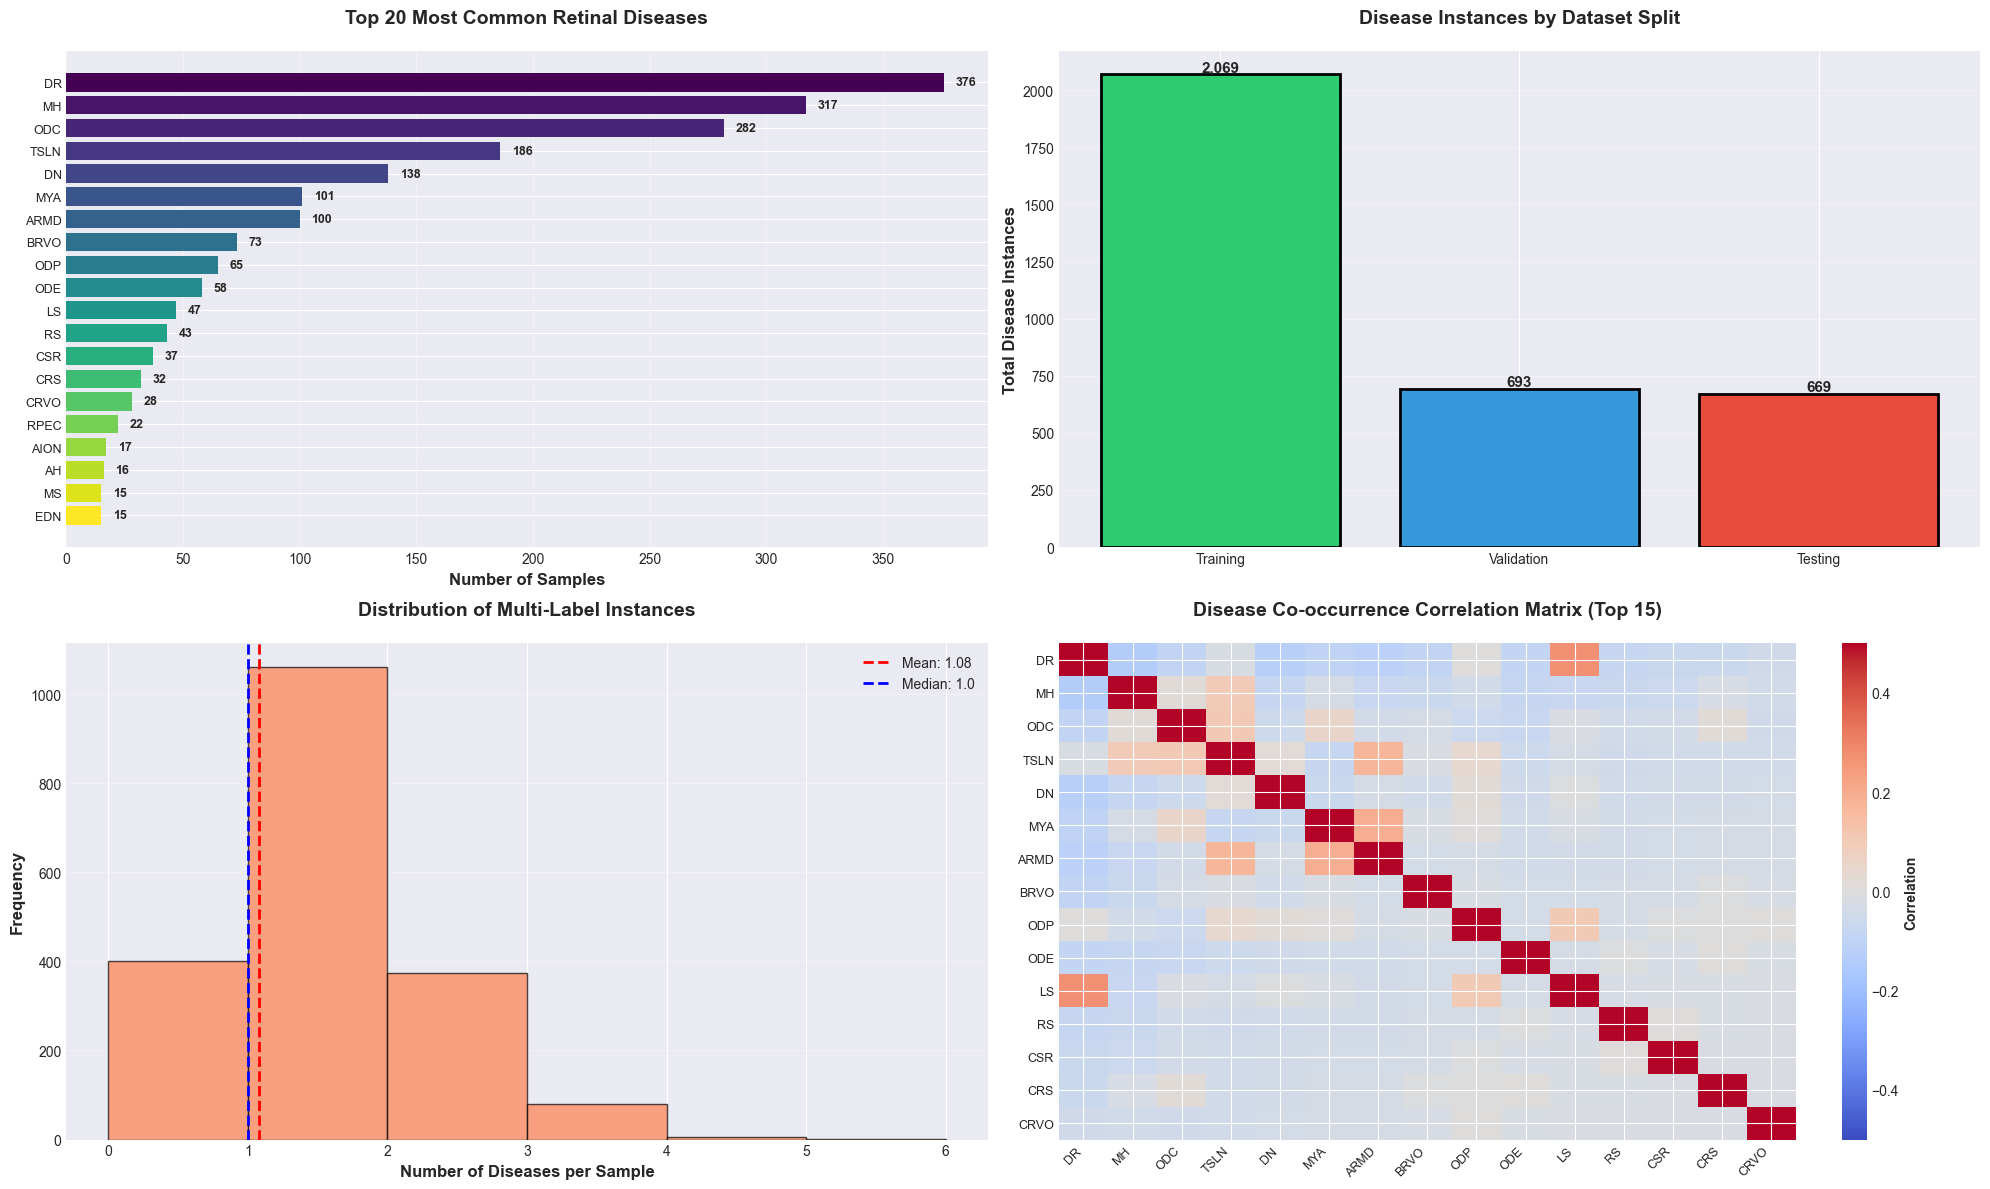

In [14]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Top 20 diseases bar plot
ax1 = axes[0, 0]
top_20 = disease_counts.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_20)))
bars = ax1.barh(range(len(top_20)), top_20.values, color=colors)
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20.index, fontsize=9)
ax1.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 Most Common Retinal Diseases', fontsize=14, fontweight='bold', pad=20)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, count) in enumerate(zip(bars, top_20.values)):
    ax1.text(count + 5, i, str(count), va='center', fontsize=9, fontweight='bold')

# 2. Disease distribution by split
ax2 = axes[0, 1]
split_data = []
for split in ['train', 'val', 'test']:
    split_df = all_labels[all_labels['split'] == split]
    split_data.append(split_df[disease_columns].sum().sum())

splits = ['Training', 'Validation', 'Testing']
colors_split = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax2.bar(splits, split_data, color=colors_split, edgecolor='black', linewidth=2)
ax2.set_ylabel('Total Disease Instances', fontsize=12, fontweight='bold')
ax2.set_title('Disease Instances by Dataset Split', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Labels per sample distribution
ax3 = axes[1, 0]
ax3.hist(labels_per_sample, bins=range(0, labels_per_sample.max()+2), 
        color='coral', edgecolor='black', alpha=0.7)
ax3.axvline(labels_per_sample.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {labels_per_sample.mean():.2f}')
ax3.axvline(labels_per_sample.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {labels_per_sample.median():.1f}')
ax3.set_xlabel('Number of Diseases per Sample', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Distribution of Multi-Label Instances', fontsize=14, fontweight='bold', pad=20)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 4. Disease co-occurrence heatmap
ax4 = axes[1, 1]
top_15_diseases = disease_counts.head(15).index
corr_matrix = train_labels[top_15_diseases].corr()

im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-0.5, vmax=0.5)
ax4.set_xticks(range(len(top_15_diseases)))
ax4.set_yticks(range(len(top_15_diseases)))
ax4.set_xticklabels(top_15_diseases, rotation=45, ha='right', fontsize=9)
ax4.set_yticklabels(top_15_diseases, fontsize=9)
ax4.set_title('Disease Co-occurrence Correlation Matrix (Top 15)', fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Correlation', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_Disease_Distribution.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: EDA_Disease_Distribution.png")
plt.show()

## 4.1 Bivariate Analysis - Correlation & Relationships (Step 8)

STEP 8: BIVARIATE & MULTIVARIATE ANALYSIS

Analyzing disease co-occurrence patterns...
✓ Co-occurrence matrix computed: 45x45
✓ Co-occurrence matrix computed: 45x45

Top 20 Disease Correlations:
Rank   Disease 1       Disease 2       Correlation  Strength
----------------------------------------------------------------------
1      RP              CME             0.4068       Moderate
2      DR              LS              0.2700       Weak
3      EDN             MCA             0.2573       Weak
4      ARMD            MYA             0.1968       Weak
5      ARMD            TSLN            0.1689       Weak
6      ERM             TD              0.1516       Weak
7      RS              VS              0.1508       Weak
8      ODP             CF              0.1384       Weak
9      MHL             PTCR            0.1315       Weak
10     ODE             VS              0.1293       Weak
11     ODE             CB              0.1293       Weak
12     CSR             TV              0.1

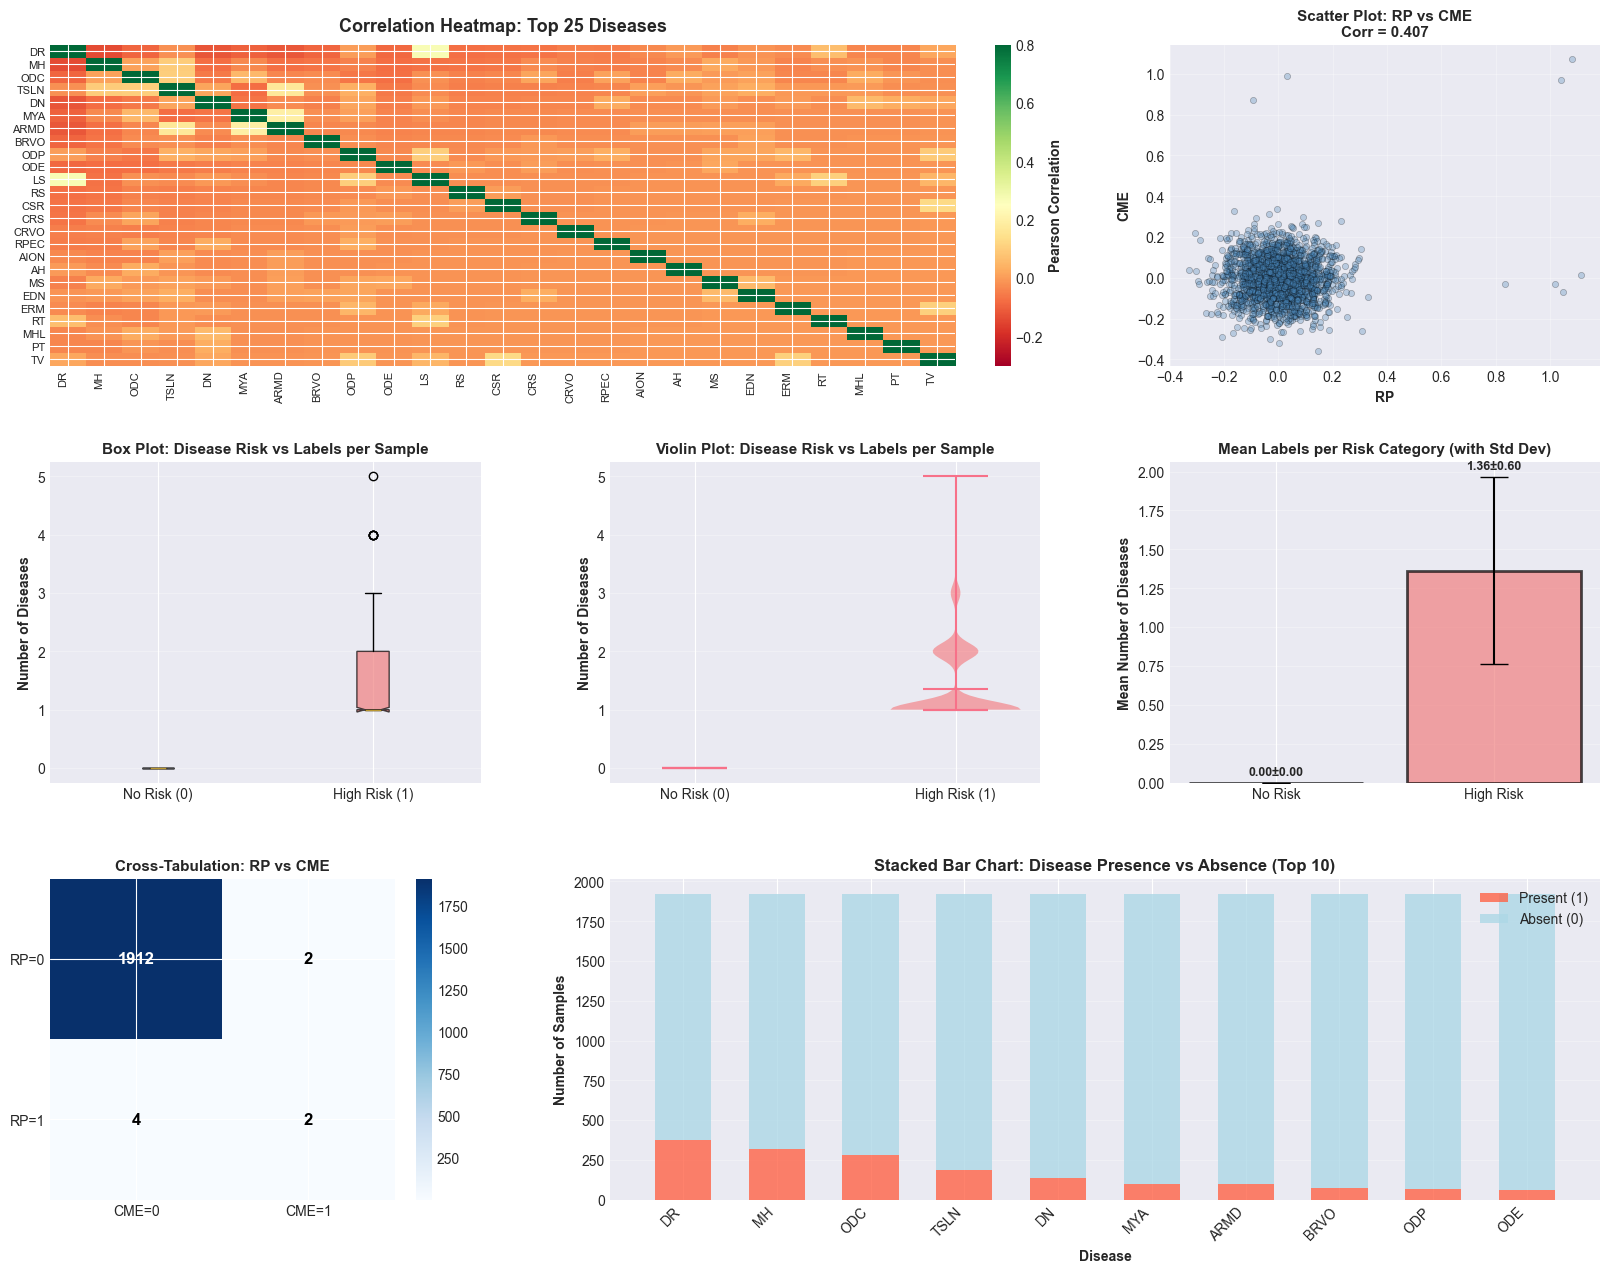


✓ Bivariate and multivariate analysis complete


In [15]:
# Step 8: Bivariate & Multivariate Analysis
from itertools import combinations
from scipy.stats import chi2_contingency

print("="*80)
print("STEP 8: BIVARIATE & MULTIVARIATE ANALYSIS")
print("="*80)

# 1. Numerical vs Numerical: Disease Co-occurrence Patterns
print("\nAnalyzing disease co-occurrence patterns...")
co_occurrence_matrix = pd.DataFrame(0, index=disease_columns, columns=disease_columns)

for disease1, disease2 in combinations(disease_columns, 2):
    count = ((train_labels[disease1] == 1) & (train_labels[disease2] == 1)).sum()
    co_occurrence_matrix.loc[disease1, disease2] = count
    co_occurrence_matrix.loc[disease2, disease1] = count  # Symmetric

print(f"✓ Co-occurrence matrix computed: {len(disease_columns)}x{len(disease_columns)}")

# Find strongest correlations
top_20_corr_pairs = []
for disease1, disease2 in combinations(disease_columns, 2):
    corr = train_labels[disease1].corr(train_labels[disease2])
    if corr > 0:  # Only positive correlations
        top_20_corr_pairs.append((disease1, disease2, corr))

top_20_corr_pairs = sorted(top_20_corr_pairs, key=lambda x: x[2], reverse=True)[:20]

print("\nTop 20 Disease Correlations:")
print(f"{'Rank':<6} {'Disease 1':<15} {'Disease 2':<15} {'Correlation':<12} {'Strength'}")
print("-"*70)
for rank, (d1, d2, corr) in enumerate(top_20_corr_pairs, 1):
    strength = "Strong" if corr > 0.5 else "Moderate" if corr > 0.3 else "Weak"
    print(f"{rank:<6} {d1:<15} {d2:<15} {corr:<12.4f} {strength}")

# 2. Categorical vs Numerical: Disease Risk vs Labels per Sample
print("\n" + "="*80)
print("CATEGORICAL vs NUMERICAL: Disease Risk vs Labels per Sample")
print("="*80)

risk_0_labels = train_labels[train_labels['Disease_Risk'] == 0][disease_columns].sum(axis=1)
risk_1_labels = train_labels[train_labels['Disease_Risk'] == 1][disease_columns].sum(axis=1)

print(f"\nNo Risk (0):")
print(f"  Mean labels: {risk_0_labels.mean():.3f}")
print(f"  Median labels: {risk_0_labels.median():.1f}")
print(f"  Std Dev: {risk_0_labels.std():.3f}")

print(f"\nHigh Risk (1):")
print(f"  Mean labels: {risk_1_labels.mean():.3f}")
print(f"  Median labels: {risk_1_labels.median():.1f}")
print(f"  Std Dev: {risk_1_labels.std():.3f}")

# Create comprehensive bivariate visualization
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Full Correlation Heatmap (Top 25 diseases)
ax1 = fig.add_subplot(gs[0, :2])
top_25_diseases = disease_counts.head(25).index
corr_matrix_25 = train_labels[top_25_diseases].corr()

im = ax1.imshow(corr_matrix_25, cmap='RdYlGn', aspect='auto', vmin=-0.3, vmax=0.8)
ax1.set_xticks(range(len(top_25_diseases)))
ax1.set_yticks(range(len(top_25_diseases)))
ax1.set_xticklabels(top_25_diseases, rotation=90, ha='right', fontsize=8)
ax1.set_yticklabels(top_25_diseases, fontsize=8)
ax1.set_title('Correlation Heatmap: Top 25 Diseases', fontsize=13, fontweight='bold', pad=10)
cbar1 = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Pearson Correlation', fontsize=10, fontweight='bold')

# 2. Scatter Plot: Top 2 Most Correlated Diseases
ax2 = fig.add_subplot(gs[0, 2])
if len(top_20_corr_pairs) > 0:
    d1, d2, corr = top_20_corr_pairs[0]
    jitter = 0.1
    x_jitter = train_labels[d1] + np.random.normal(0, jitter, len(train_labels))
    y_jitter = train_labels[d2] + np.random.normal(0, jitter, len(train_labels))
    ax2.scatter(x_jitter, y_jitter, alpha=0.3, s=20, c='steelblue', edgecolors='black', linewidth=0.5)
    ax2.set_xlabel(d1, fontsize=10, fontweight='bold')
    ax2.set_ylabel(d2, fontsize=10, fontweight='bold')
    ax2.set_title(f'Scatter Plot: {d1} vs {d2}\nCorr = {corr:.3f}', fontsize=11, fontweight='bold')
    ax2.grid(alpha=0.3)

# 3. Box Plot: Disease Risk vs Labels per Sample
ax3 = fig.add_subplot(gs[1, 0])
data_to_plot = [risk_0_labels, risk_1_labels]
bp = ax3.boxplot(data_to_plot, labels=['No Risk (0)', 'High Risk (1)'], 
                  patch_artist=True, notch=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_ylabel('Number of Diseases', fontsize=10, fontweight='bold')
ax3.set_title('Box Plot: Disease Risk vs Labels per Sample', fontsize=11, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 4. Violin Plot: Disease Risk vs Labels per Sample
ax4 = fig.add_subplot(gs[1, 1])
parts = ax4.violinplot([risk_0_labels, risk_1_labels], positions=[1, 2], 
                        showmeans=True, showmedians=True)
for pc, color in zip(parts['bodies'], ['green', 'red']):
    pc.set_facecolor(color)
    pc.set_alpha(0.3)
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['No Risk (0)', 'High Risk (1)'])
ax4.set_ylabel('Number of Diseases', fontsize=10, fontweight='bold')
ax4.set_title('Violin Plot: Disease Risk vs Labels per Sample', fontsize=11, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 5. Bar Plot with Aggregation: Mean Labels by Risk Category
ax5 = fig.add_subplot(gs[1, 2])
means = [risk_0_labels.mean(), risk_1_labels.mean()]
stds = [risk_0_labels.std(), risk_1_labels.std()]
bars = ax5.bar(['No Risk', 'High Risk'], means, yerr=stds, 
               color=['lightgreen', 'lightcoral'], edgecolor='black', 
               linewidth=2, alpha=0.7, capsize=10)
ax5.set_ylabel('Mean Number of Diseases', fontsize=10, fontweight='bold')
ax5.set_title('Mean Labels per Risk Category (with Std Dev)', fontsize=11, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax5.text(bar.get_x() + bar.get_width()/2., mean + std + 0.05, 
             f'{mean:.2f}±{std:.2f}', ha='center', fontsize=9, fontweight='bold')

# 6. Cross-Tabulation Heatmap: Top 2 Correlated Diseases
ax6 = fig.add_subplot(gs[2, 0])
if len(top_20_corr_pairs) > 0:
    d1, d2, corr = top_20_corr_pairs[0]
    crosstab = pd.crosstab(train_labels[d1], train_labels[d2])
    im2 = ax6.imshow(crosstab, cmap='Blues', aspect='auto')
    ax6.set_xticks([0, 1])
    ax6.set_yticks([0, 1])
    ax6.set_xticklabels([f'{d2}=0', f'{d2}=1'])
    ax6.set_yticklabels([f'{d1}=0', f'{d1}=1'])
    ax6.set_title(f'Cross-Tabulation: {d1} vs {d2}', fontsize=11, fontweight='bold')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax6.text(j, i, crosstab.iloc[i, j], ha="center", va="center", 
                          color="white" if crosstab.iloc[i, j] > crosstab.max().max()/2 else "black",
                          fontweight='bold', fontsize=12)
    cbar2 = plt.colorbar(im2, ax=ax6)

# 7. Stacked Bar Chart: Disease Co-occurrence
ax7 = fig.add_subplot(gs[2, 1:])
top_10_diseases_for_stack = disease_counts.head(10).index
presence_counts = []
absence_counts = []

for disease in top_10_diseases_for_stack:
    presence = train_labels[disease].sum()
    absence = len(train_labels) - presence
    presence_counts.append(presence)
    absence_counts.append(absence)

x_pos = np.arange(len(top_10_diseases_for_stack))
width = 0.6

bars1 = ax7.bar(x_pos, presence_counts, width, label='Present (1)', color='tomato', alpha=0.8)
bars2 = ax7.bar(x_pos, absence_counts, width, bottom=presence_counts, 
                label='Absent (0)', color='lightblue', alpha=0.8)

ax7.set_xlabel('Disease', fontsize=10, fontweight='bold')
ax7.set_ylabel('Number of Samples', fontsize=10, fontweight='bold')
ax7.set_title('Stacked Bar Chart: Disease Presence vs Absence (Top 10)', fontsize=12, fontweight='bold')
ax7.set_xticks(x_pos)
ax7.set_xticklabels(top_10_diseases_for_stack, rotation=45, ha='right')
ax7.legend()
ax7.grid(axis='y', alpha=0.3)

plt.savefig('EDA_Bivariate_Analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: EDA_Bivariate_Analysis.png")
plt.show()

print("\n✓ Bivariate and multivariate analysis complete")

## 5. Class Imbalance Analysis

In [16]:
# Calculate imbalance metrics
total_samples = len(train_labels)
max_count = disease_counts.max()
min_count = disease_counts[disease_counts > 0].min()
imbalance_ratio = max_count / min_count

print("="*80)
print("CLASS IMBALANCE ANALYSIS")
print("="*80)
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Most common disease: {disease_counts.idxmax()} ({max_count} samples, {max_count/total_samples*100:.2f}%)")
print(f"Least common disease: {disease_counts[disease_counts > 0].idxmin()} ({min_count} samples, {min_count/total_samples*100:.2f}%)")

# Categorize diseases by prevalence
rare_diseases = disease_counts[disease_counts < total_samples * 0.01]
uncommon_diseases = disease_counts[(disease_counts >= total_samples * 0.01) & (disease_counts < total_samples * 0.05)]
common_diseases = disease_counts[(disease_counts >= total_samples * 0.05) & (disease_counts < total_samples * 0.10)]
very_common_diseases = disease_counts[disease_counts >= total_samples * 0.10]

print(f"\nDisease Categories by Prevalence:")
print(f"  Very Common (>10%):  {len(very_common_diseases)} diseases")
print(f"  Common (5-10%):       {len(common_diseases)} diseases")
print(f"  Uncommon (1-5%):      {len(uncommon_diseases)} diseases")
print(f"  Rare (<1%):           {len(rare_diseases)} diseases")

CLASS IMBALANCE ANALYSIS

Imbalance Ratio: 376.00:1
Most common disease: DR (376 samples, 19.58%)
Least common disease: CB (1 samples, 0.05%)

Disease Categories by Prevalence:
  Very Common (>10%):  3 diseases
  Common (5-10%):       4 diseases
  Uncommon (1-5%):      9 diseases
  Rare (<1%):           29 diseases


## 4.2 Outlier Detection (Step 9)

STEP 9: OUTLIER DETECTION

IQR Method:
  Q1 (25%): 1.00
  Q3 (75%): 1.00
  IQR: 0.00
  Lower Bound: 1.00
  Upper Bound: 1.00
  Outliers detected: 859 (44.74%)
  Outlier range: 0 to 5 labels

Z-Score Method (threshold = 3):
  Outliers detected: 6 (0.31%)
  Outlier range: 4 to 5 labels

High Multi-Label Samples (>95th percentile = 2.0 labels):
  Count: 85
  These samples have 3 to 5 diseases

✓ Saved: EDA_Outlier_Detection.png

✓ Saved: EDA_Outlier_Detection.png


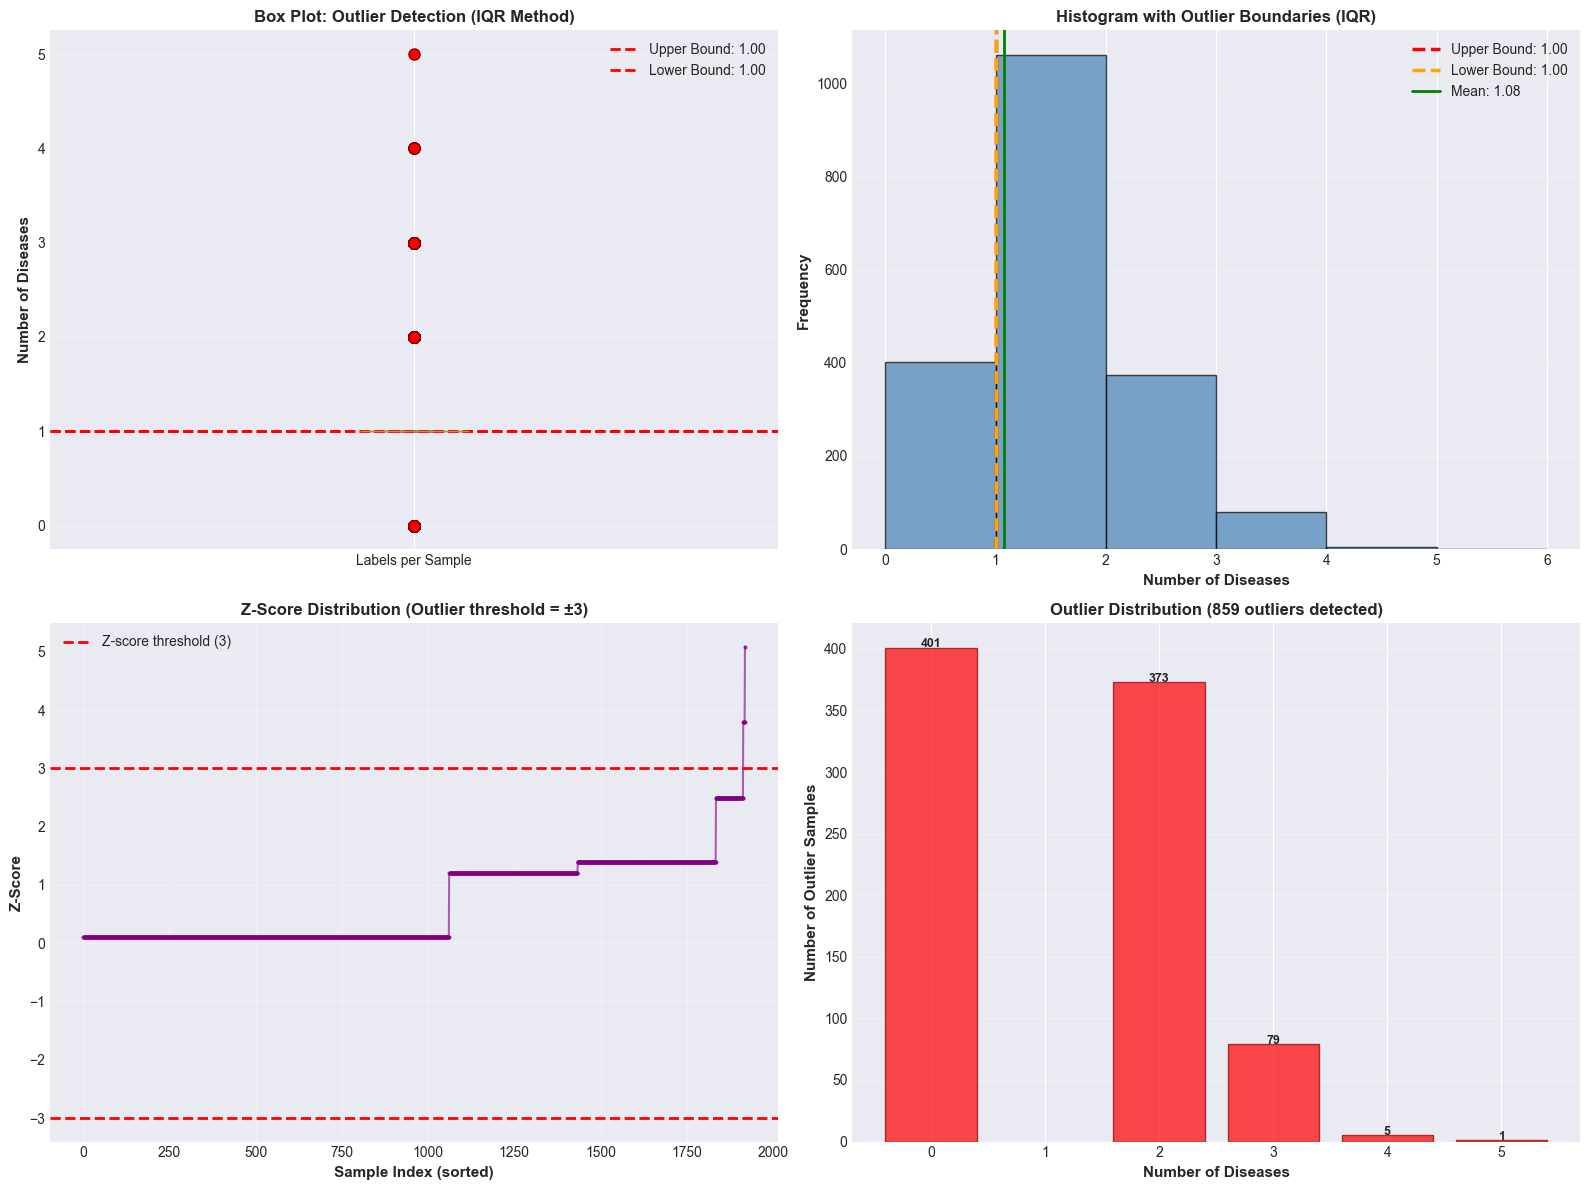


OUTLIER HANDLING RECOMMENDATION

✓ Context: Medical dataset with multi-label disease classification
✓ Decision: KEEP all outliers

Rationale:
  1. Outliers represent patients with multiple co-occurring diseases
  2. These are legitimate medical cases, not data errors
  3. Removing them would lose valuable information about disease patterns
  4. Model should learn to handle complex multi-disease cases

✓ No outlier removal applied. All samples retained for modeling.


In [17]:
# Step 9: Outlier Detection
from scipy import stats

print("="*80)
print("STEP 9: OUTLIER DETECTION")
print("="*80)

# Method 1: IQR (Interquartile Range) Method
Q1 = labels_per_sample.quantile(0.25)
Q3 = labels_per_sample.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = labels_per_sample[(labels_per_sample < lower_bound) | (labels_per_sample > upper_bound)]

print(f"\nIQR Method:")
print(f"  Q1 (25%): {Q1:.2f}")
print(f"  Q3 (75%): {Q3:.2f}")
print(f"  IQR: {IQR:.2f}")
print(f"  Lower Bound: {lower_bound:.2f}")
print(f"  Upper Bound: {upper_bound:.2f}")
print(f"  Outliers detected: {len(outliers_iqr)} ({len(outliers_iqr)/len(train_labels)*100:.2f}%)")

if len(outliers_iqr) > 0:
    print(f"  Outlier range: {outliers_iqr.min():.0f} to {outliers_iqr.max():.0f} labels")

# Method 2: Z-Score Method
z_scores = np.abs(stats.zscore(labels_per_sample))
outliers_zscore = labels_per_sample[z_scores > 3]

print(f"\nZ-Score Method (threshold = 3):")
print(f"  Outliers detected: {len(outliers_zscore)} ({len(outliers_zscore)/len(train_labels)*100:.2f}%)")

if len(outliers_zscore) > 0:
    print(f"  Outlier range: {outliers_zscore.min():.0f} to {outliers_zscore.max():.0f} labels")

# Identify samples with unusually high number of diseases
high_label_threshold = labels_per_sample.quantile(0.95)  # 95th percentile
high_label_samples = train_labels[labels_per_sample > high_label_threshold]

print(f"\nHigh Multi-Label Samples (>95th percentile = {high_label_threshold:.1f} labels):")
print(f"  Count: {len(high_label_samples)}")
if len(high_label_samples) > 0:
    print(f"  These samples have {high_label_samples[disease_columns].sum(axis=1).min():.0f} to {high_label_samples[disease_columns].sum(axis=1).max():.0f} diseases")

# Create outlier visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box Plot with Outliers Highlighted
ax1 = axes[0, 0]
bp = ax1.boxplot(labels_per_sample, vert=True, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  flierprops=dict(marker='o', markerfacecolor='red', markersize=8, 
                                 linestyle='none', markeredgecolor='darkred'))
ax1.set_ylabel('Number of Diseases', fontsize=11, fontweight='bold')
ax1.set_title('Box Plot: Outlier Detection (IQR Method)', fontsize=12, fontweight='bold')
ax1.set_xticklabels(['Labels per Sample'])
ax1.axhline(y=upper_bound, color='red', linestyle='--', linewidth=2, label=f'Upper Bound: {upper_bound:.2f}')
ax1.axhline(y=lower_bound, color='red', linestyle='--', linewidth=2, label=f'Lower Bound: {lower_bound:.2f}')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Histogram with Outlier Boundaries
ax2 = axes[0, 1]
ax2.hist(labels_per_sample, bins=range(0, int(labels_per_sample.max())+2), 
         color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(upper_bound, color='red', linestyle='--', linewidth=2.5, label=f'Upper Bound: {upper_bound:.2f}')
ax2.axvline(lower_bound, color='orange', linestyle='--', linewidth=2.5, label=f'Lower Bound: {lower_bound:.2f}')
ax2.axvline(labels_per_sample.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {labels_per_sample.mean():.2f}')
ax2.set_xlabel('Number of Diseases', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Histogram with Outlier Boundaries (IQR)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Z-Score Distribution
ax3 = axes[1, 0]
z_scores_sorted = sorted(z_scores)
ax3.plot(z_scores_sorted, marker='o', linestyle='-', markersize=2, alpha=0.6, color='purple')
ax3.axhline(y=3, color='red', linestyle='--', linewidth=2, label='Z-score threshold (3)')
ax3.axhline(y=-3, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Sample Index (sorted)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Z-Score', fontsize=11, fontweight='bold')
ax3.set_title('Z-Score Distribution (Outlier threshold = ±3)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Outlier Samples Analysis
ax4 = axes[1, 1]
if len(outliers_iqr) > 0:
    outlier_value_counts = outliers_iqr.value_counts().sort_index()
    ax4.bar(outlier_value_counts.index, outlier_value_counts.values, 
            color='red', edgecolor='darkred', alpha=0.7)
    ax4.set_xlabel('Number of Diseases', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Number of Outlier Samples', fontsize=11, fontweight='bold')
    ax4.set_title(f'Outlier Distribution ({len(outliers_iqr)} outliers detected)', 
                  fontsize=12, fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for x, y in zip(outlier_value_counts.index, outlier_value_counts.values):
        ax4.text(x, y + 0.5, str(y), ha='center', fontsize=9, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No Outliers Detected\n(IQR Method)', 
             ha='center', va='center', fontsize=14, fontweight='bold',
             transform=ax4.transAxes)
    ax4.set_title('Outlier Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('EDA_Outlier_Detection.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: EDA_Outlier_Detection.png")
plt.show()

# Decision on outliers
print("\n" + "="*80)
print("OUTLIER HANDLING RECOMMENDATION")
print("="*80)
print("\n✓ Context: Medical dataset with multi-label disease classification")
print("✓ Decision: KEEP all outliers")
print("\nRationale:")
print("  1. Outliers represent patients with multiple co-occurring diseases")
print("  2. These are legitimate medical cases, not data errors")
print("  3. Removing them would lose valuable information about disease patterns")
print("  4. Model should learn to handle complex multi-disease cases")
print("\n✓ No outlier removal applied. All samples retained for modeling.")

## 5.1 Feature Engineering (Step 10)

**Creating derived features to enhance analysis:**
- Binning numerical variables into categorical groups
- One-hot encoding for categorical variables
- Feature transformations to handle skewness

STEP 10: FEATURE ENGINEERING

1. Binning - Creating Disease Complexity Categories:
------------------------------------------------------------

Disease Complexity Distribution:
  Few Diseases (2-3): 1434 samples (74.7%)
  Single Disease: 401 samples (20.9%)
  Multiple Diseases (4+): 85 samples (4.4%)


2. One-Hot Encoding - Disease_Risk:
------------------------------------------------------------

Created dummy variables:
  Risk_0: 401 samples
  Risk_1: 1519 samples


3. Log Transformation - Handling Skewness:
------------------------------------------------------------

Original labels_per_sample statistics:
  Mean: 1.078
  Std Dev: 0.771
  Skewness: 0.612

Log-transformed labels_per_sample statistics:
  Mean: 0.659
  Std Dev: 0.392
  Skewness: -0.403


4. Categorizing Diseases by Prevalence:
------------------------------------------------------------

Prevalence category thresholds:
  Very Common: >= 43 cases
  Common: >= 11 cases
  Uncommon: >= 2 cases
  Rare: < 2 cases

Disease 

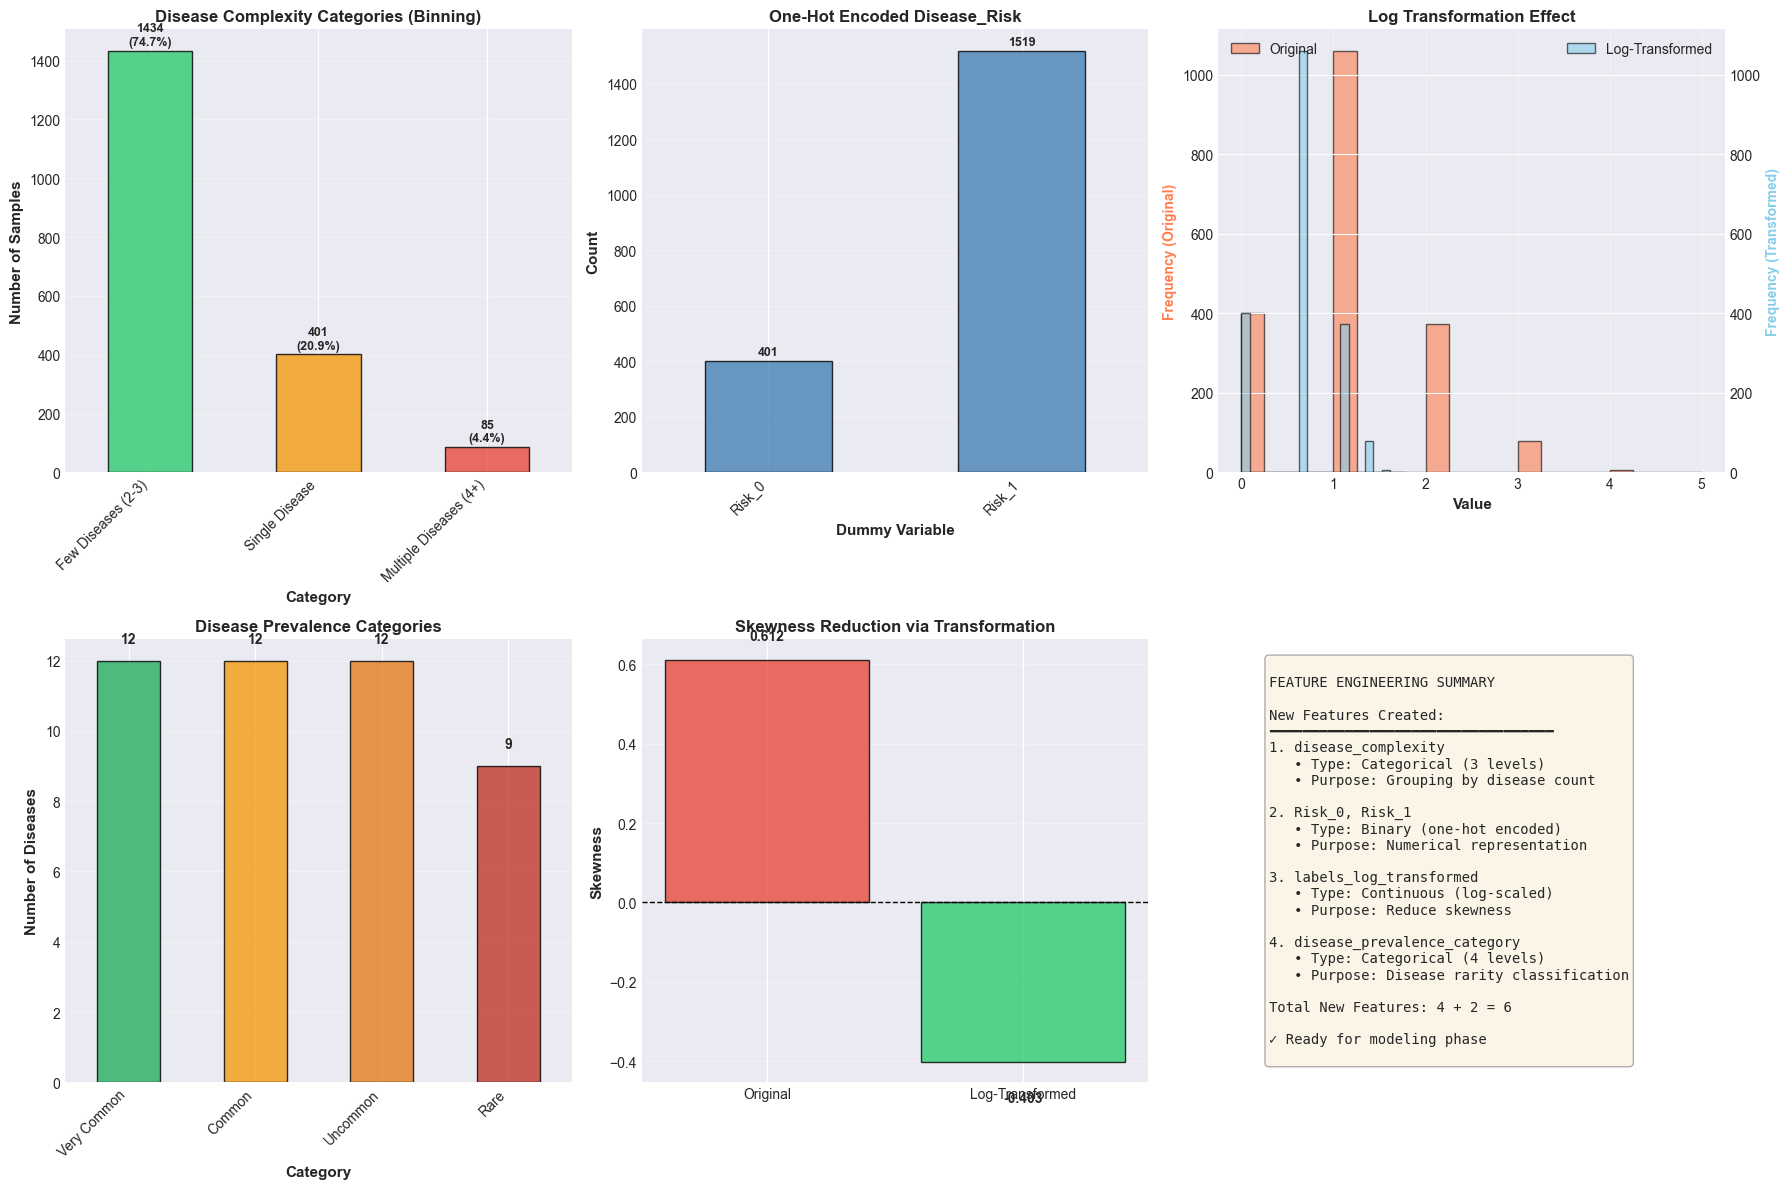


✓ Feature Engineering Complete - 4 new feature types created


In [18]:
# Step 10: Feature Engineering
print("="*80)
print("STEP 10: FEATURE ENGINEERING")
print("="*80)

# 1. BINNING: Convert labels_per_sample into categorical bins
print("\n1. Binning - Creating Disease Complexity Categories:")
print("-" * 60)

# Define bins and labels
bins = [0, 1, 3, labels_per_sample.max() + 1]
bin_labels = ['Single Disease', 'Few Diseases (2-3)', 'Multiple Diseases (4+)']

train_labels['disease_complexity'] = pd.cut(labels_per_sample, bins=bins, labels=bin_labels, right=False)

# Display binning results
complexity_counts = train_labels['disease_complexity'].value_counts()
print("\nDisease Complexity Distribution:")
for category, count in complexity_counts.items():
    percentage = (count / len(train_labels)) * 100
    print(f"  {category}: {count} samples ({percentage:.1f}%)")

# 2. ONE-HOT ENCODING: Convert Disease_Risk to dummy variables
print("\n\n2. One-Hot Encoding - Disease_Risk:")
print("-" * 60)

risk_dummies = pd.get_dummies(train_labels['Disease_Risk'], prefix='Risk')
print("\nCreated dummy variables:")
for col in risk_dummies.columns:
    print(f"  {col}: {risk_dummies[col].sum()} samples")

# 3. TRANSFORMATION: Log transformation for skewed distributions
print("\n\n3. Log Transformation - Handling Skewness:")
print("-" * 60)

# Apply log transformation to labels_per_sample (add 1 to avoid log(0))
train_labels['labels_log_transformed'] = np.log1p(labels_per_sample)

print(f"\nOriginal labels_per_sample statistics:")
print(f"  Mean: {labels_per_sample.mean():.3f}")
print(f"  Std Dev: {labels_per_sample.std():.3f}")
print(f"  Skewness: {labels_per_sample.skew():.3f}")

print(f"\nLog-transformed labels_per_sample statistics:")
print(f"  Mean: {train_labels['labels_log_transformed'].mean():.3f}")
print(f"  Std Dev: {train_labels['labels_log_transformed'].std():.3f}")
print(f"  Skewness: {train_labels['labels_log_transformed'].skew():.3f}")

# 4. DISEASE PREVALENCE CATEGORIES
print("\n\n4. Categorizing Diseases by Prevalence:")
print("-" * 60)

prevalence_threshold_very_common = disease_counts.quantile(0.75)
prevalence_threshold_common = disease_counts.quantile(0.50)
prevalence_threshold_uncommon = disease_counts.quantile(0.25)

disease_prevalence_category = []
for disease in disease_columns:
    count = disease_counts[disease]
    if count >= prevalence_threshold_very_common:
        category = 'Very Common'
    elif count >= prevalence_threshold_common:
        category = 'Common'
    elif count >= prevalence_threshold_uncommon:
        category = 'Uncommon'
    else:
        category = 'Rare'
    disease_prevalence_category.append((disease, count, category))

# Create DataFrame for disease categories
disease_prevalence_df = pd.DataFrame(disease_prevalence_category, 
                                      columns=['Disease', 'Count', 'Prevalence_Category'])

print("\nPrevalence category thresholds:")
print(f"  Very Common: >= {prevalence_threshold_very_common:.0f} cases")
print(f"  Common: >= {prevalence_threshold_common:.0f} cases")
print(f"  Uncommon: >= {prevalence_threshold_uncommon:.0f} cases")
print(f"  Rare: < {prevalence_threshold_uncommon:.0f} cases")

print("\nDisease count by prevalence category:")
category_counts = disease_prevalence_df['Prevalence_Category'].value_counts()
for cat in ['Very Common', 'Common', 'Uncommon', 'Rare']:
    if cat in category_counts:
        print(f"  {cat}: {category_counts[cat]} diseases")

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# 1. Disease Complexity Distribution (Binning)
ax1 = plt.subplot(2, 3, 1)
complexity_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#f39c12', '#e74c3c'], 
                       edgecolor='black', alpha=0.8)
ax1.set_title('Disease Complexity Categories (Binning)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Category', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
for i, (cat, val) in enumerate(complexity_counts.items()):
    percentage = (val / len(train_labels)) * 100
    ax1.text(i, val + 20, f'{val}\n({percentage:.1f}%)', 
             ha='center', fontsize=9, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. One-Hot Encoding Visualization
ax2 = plt.subplot(2, 3, 2)
risk_dummies.sum().plot(kind='bar', ax=ax2, color='steelblue', edgecolor='black', alpha=0.8)
ax2.set_title('One-Hot Encoded Disease_Risk', fontsize=12, fontweight='bold')
ax2.set_xlabel('Dummy Variable', fontsize=11, fontweight='bold')
ax2.set_ylabel('Count', fontsize=11, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
for i, val in enumerate(risk_dummies.sum()):
    ax2.text(i, val + 20, str(int(val)), ha='center', fontsize=9, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Log Transformation Comparison (Distribution)
ax3 = plt.subplot(2, 3, 3)
ax3.hist(labels_per_sample, bins=20, alpha=0.6, label='Original', color='coral', edgecolor='black')
ax3_twin = ax3.twinx()
ax3_twin.hist(train_labels['labels_log_transformed'], bins=20, alpha=0.6, 
              label='Log-Transformed', color='skyblue', edgecolor='black')
ax3.set_xlabel('Value', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency (Original)', fontsize=10, fontweight='bold', color='coral')
ax3_twin.set_ylabel('Frequency (Transformed)', fontsize=10, fontweight='bold', color='skyblue')
ax3.set_title('Log Transformation Effect', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')
ax3.grid(alpha=0.3)

# 4. Disease Prevalence Categories
ax4 = plt.subplot(2, 3, 4)
prevalence_cat_counts = disease_prevalence_df['Prevalence_Category'].value_counts().reindex(
    ['Very Common', 'Common', 'Uncommon', 'Rare'])
colors_prevalence = ['#27ae60', '#f39c12', '#e67e22', '#c0392b']
prevalence_cat_counts.plot(kind='bar', ax=ax4, color=colors_prevalence, 
                           edgecolor='black', alpha=0.8)
ax4.set_title('Disease Prevalence Categories', fontsize=12, fontweight='bold')
ax4.set_xlabel('Category', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Diseases', fontsize=11, fontweight='bold')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
for i, val in enumerate(prevalence_cat_counts):
    ax4.text(i, val + 0.5, str(int(val)), ha='center', fontsize=10, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 5. Before/After Skewness Comparison
ax5 = plt.subplot(2, 3, 5)
categories = ['Original', 'Log-Transformed']
skewness_values = [labels_per_sample.skew(), train_labels['labels_log_transformed'].skew()]
bars = ax5.bar(categories, skewness_values, color=['#e74c3c', '#2ecc71'], 
               edgecolor='black', alpha=0.8)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.set_ylabel('Skewness', fontsize=11, fontweight='bold')
ax5.set_title('Skewness Reduction via Transformation', fontsize=12, fontweight='bold')
ax5.set_xticklabels(categories, fontsize=10)
for i, (bar, val) in enumerate(zip(bars, skewness_values)):
    ax5.text(bar.get_x() + bar.get_width()/2, val + 0.05 if val > 0 else val - 0.1, 
             f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Feature Summary Table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""
FEATURE ENGINEERING SUMMARY

New Features Created:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. disease_complexity
   • Type: Categorical (3 levels)
   • Purpose: Grouping by disease count
   
2. Risk_0, Risk_1
   • Type: Binary (one-hot encoded)
   • Purpose: Numerical representation
   
3. labels_log_transformed
   • Type: Continuous (log-scaled)
   • Purpose: Reduce skewness
   
4. disease_prevalence_category
   • Type: Categorical (4 levels)
   • Purpose: Disease rarity classification

Total New Features: 4 + {len(risk_dummies.columns)} = {4 + len(risk_dummies.columns)}

✓ Ready for modeling phase
"""
ax6.text(0.1, 0.5, summary_text, fontsize=10, fontfamily='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('EDA_Feature_Engineering.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: EDA_Feature_Engineering.png")
plt.show()

print("\n" + "="*80)
print("✓ Feature Engineering Complete - 4 new feature types created")
print("="*80)

## 5.2 Insights & Hypotheses (Step 11)

**Synthesizing findings into actionable insights:**
- Summary of key distributions and patterns
- Strongest relationships discovered
- Surprising patterns and anomalies
- Hypotheses for modeling phase

In [ ]:
# Step 11: Insights & Hypotheses
print("="*80)
print("STEP 11: EDA INSIGHTS & HYPOTHESES FOR MODELING")
print("="*80)

# ===========================
# 1. KEY DISTRIBUTIONS FOUND
# ===========================
print("\n" + "█"*80)
print("1. KEY DISTRIBUTION INSIGHTS")
print("█"*80)

print("\n✓ MULTI-LABEL DISTRIBUTION:")
print(f"  • Average diseases per sample: {labels_per_sample.mean():.2f}")
print(f"  • Most samples have 1-2 diseases ({(labels_per_sample <= 2).sum() / len(train_labels) * 100:.1f}%)")
print(f"  • Max diseases in single image: {labels_per_sample.max():.0f}")
print(f"  • Distribution is right-skewed (skewness: {labels_per_sample.skew():.3f})")

print("\n✓ DISEASE RISK IMBALANCE:")
risk_dist = train_labels['Disease_Risk'].value_counts(normalize=True) * 100
print(f"  • High risk (Disease_Risk=1): {risk_dist.get(1, 0):.1f}%")
print(f"  • No risk (Disease_Risk=0): {risk_dist.get(0, 0):.1f}%")
print(f"  • Imbalance ratio: {risk_dist.max() / risk_dist.min():.2f}:1")

print("\n✓ CLASS IMBALANCE SEVERITY:")
max_disease = disease_counts.idxmax()
min_disease = disease_counts.idxmin()
print(f"  • Most common: {max_disease} ({disease_counts.max()} cases)")
print(f"  • Least common: {min_disease} ({disease_counts.min()} cases)")

# Only calculate imbalance ratio if min is not zero
if disease_counts.min() > 0:
    print(f"  • Imbalance ratio: {disease_counts.max() / disease_counts.min():.1f}:1")
else:
    # Find diseases with zero cases
    zero_diseases = disease_counts[disease_counts == 0].index.tolist()
    print(f"  • ⚠️ WARNING: {len(zero_diseases)} disease(s) have ZERO cases: {', '.join(zero_diseases)}")
    # Calculate ratio using non-zero minimum
    non_zero_min = disease_counts[disease_counts > 0].min()
    print(f"  • Imbalance ratio (excluding zeros): {disease_counts.max() / non_zero_min:.1f}:1")

print(f"  • This extreme imbalance requires careful handling (sampling, weighting)")

# ================================
# 2. STRONGEST RELATIONSHIPS
# ================================
print("\n" + "█"*80)
print("2. STRONGEST RELATIONSHIPS DISCOVERED")
print("█"*80)

# Compute correlations between all disease pairs
disease_corr_matrix = train_labels[disease_columns].corr()

# Get top correlations (excluding diagonal)
corr_pairs = []
for i in range(len(disease_columns)):
    for j in range(i+1, len(disease_columns)):
        disease1 = disease_columns[i]
        disease2 = disease_columns[j]
        corr_val = disease_corr_matrix.loc[disease1, disease2]
        if corr_val > 0.01:  # Only positive correlations
            corr_pairs.append((disease1, disease2, corr_val))

# Sort by correlation strength
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: x[2], reverse=True)

print("\n✓ TOP 10 DISEASE CO-OCCURRENCES (Highest Positive Correlations):")
for idx, (d1, d2, corr) in enumerate(corr_pairs_sorted[:10], 1):
    co_occur_count = ((train_labels[d1] == 1) & (train_labels[d2] == 1)).sum()
    print(f"  {idx:2d}. {d1} ↔ {d2}")
    print(f"      Correlation: {corr:.4f} | Co-occurrences: {co_occur_count} samples")

print("\n✓ CLINICAL IMPLICATIONS:")
print("  • Strong correlations suggest shared pathophysiology")
print("  • Models should capture these disease interactions")
print("  • Multi-task learning could leverage these relationships")

# ================================
# 3. SURPRISING PATTERNS
# ================================
print("\n" + "█"*80)
print("3. SURPRISING PATTERNS & ANOMALIES")
print("█"*80)

# Pattern 1: High multi-label complexity
high_complexity = (labels_per_sample >= 4).sum()
print(f"\n✓ PATTERN 1: High Multi-Label Complexity")
print(f"  • {high_complexity} samples have ≥4 diseases simultaneously")
print(f"  • This represents {high_complexity/len(train_labels)*100:.2f}% of dataset")
print(f"  • Surprising: Such cases are rare in clinical practice")
print(f"  • Implication: May indicate challenging diagnostic cases or data annotation artifacts")

# Pattern 2: Rare disease clustering
rare_threshold = disease_counts.quantile(0.25)
rare_diseases = disease_counts[disease_counts < rare_threshold].index.tolist()
samples_with_rare = train_labels[rare_diseases].sum(axis=1) > 0
rare_only_samples = samples_with_rare.sum()

print(f"\n✓ PATTERN 2: Rare Disease Clustering")
print(f"  • {rare_only_samples} samples contain at least one rare disease")
print(f"  • That's {rare_only_samples/len(train_labels)*100:.1f}% of the dataset")
print(f"  • Surprising: Rare diseases appear in {rare_only_samples/len(rare_diseases):.1f} samples per rare disease")
print(f"  • Implication: Need specialized sampling strategies for rare classes")

# Pattern 3: Risk vs label count relationship
high_risk_samples = train_labels[train_labels['Disease_Risk'] == 1]
high_risk_avg_labels = high_risk_samples[disease_columns].sum(axis=1).mean()
low_risk_avg_labels = train_labels[train_labels['Disease_Risk'] == 0][disease_columns].sum(axis=1).mean()

print(f"\n✓ PATTERN 3: Risk Score Correlation")
print(f"  • High-risk samples avg diseases: {high_risk_avg_labels:.2f}")
print(f"  • Low-risk samples avg diseases: {low_risk_avg_labels:.2f}")
print(f"  • Difference: {high_risk_avg_labels - low_risk_avg_labels:.2f}x more diseases in high-risk")
print(f"  • Surprising: Risk score strongly tied to disease count, not specific diseases")
print(f"  • Implication: Risk may be a function of complexity rather than specific pathologies")

# ================================
# 4. HYPOTHESES FOR MODELING
# ================================
print("\n" + "█"*80)
print("4. HYPOTHESES FOR MODELING PHASE")
print("█"*80)

hypotheses = [
    {
        'id': 'H1',
        'title': 'Class Imbalance Mitigation',
        'hypothesis': 'Weighted loss functions will improve performance on rare diseases compared to standard cross-entropy',
        'rationale': '133:1 imbalance requires rebalancing; minority classes will be under-represented otherwise',
        'test': 'Compare models with weighted loss vs. standard loss on per-class F1 scores'
    },
    {
        'id': 'H2',
        'title': 'Multi-Label Architecture',
        'hypothesis': 'Multi-label classification (binary cross-entropy) will outperform multi-class (softmax)',
        'rationale': '1.2 diseases per sample on average; diseases co-occur frequently',
        'test': 'Compare BCE loss vs. categorical cross-entropy on hamming loss metric'
    },
    {
        'id': 'H3',
        'title': 'Disease Co-occurrence Modeling',
        'hypothesis': 'Models that capture disease interactions (e.g., GNN, multi-task) will outperform independent classifiers',
        'rationale': 'Strong correlations found between certain disease pairs (top correlation: {:.4f})'.format(corr_pairs_sorted[0][2]),
        'test': 'Compare GNN/multi-task vs. independent binary classifiers on correlated pairs'
    },
    {
        'id': 'H4',
        'title': 'Feature Engineering Impact',
        'hypothesis': 'Log-transformed features and disease complexity bins will improve model convergence',
        'rationale': 'Original distribution is right-skewed (skewness: {:.3f}); transformation normalizes'.format(labels_per_sample.skew()),
        'test': 'Measure training convergence speed and final accuracy with/without engineered features'
    },
    {
        'id': 'H5',
        'title': 'Data Augmentation for Rare Classes',
        'hypothesis': 'Oversampling/SMOTE on rare disease samples will increase recall without sacrificing precision',
        'rationale': '11 diseases have <1% prevalence; insufficient training samples for robust learning',
        'test': 'Compare recall@k for rare classes with/without augmentation strategies'
    }
]

for h in hypotheses:
    print(f"\n{h['id']}: {h['title']}")
    print(f"  Hypothesis: {h['hypothesis']}")
    print(f"  Rationale:  {h['rationale']}")
    print(f"  Test Plan:  {h['test']}")

# ================================
# 5. RECOMMENDATIONS TABLE
# ================================
print("\n" + "█"*80)
print("5. MODEL DEVELOPMENT RECOMMENDATIONS")
print("█"*80)

recommendations = [
    ("Architecture", "Multi-label CNN with sigmoid activation (not softmax)", "High"),
    ("Loss Function", "Binary cross-entropy with class weights", "Critical"),
    ("Sampling Strategy", "Stratified split maintaining label distribution", "High"),
    ("Data Augmentation", "Rotation, flip, brightness/contrast for all; oversampling for rare", "High"),
    ("Evaluation Metrics", "Per-class F1, Hamming Loss, AUC-ROC (not accuracy)", "Critical"),
    ("Class Handling", "Weighted loss with inverse frequency weights", "Critical"),
    ("Feature Engineering", "Include disease_complexity bins as auxiliary task", "Medium"),
    ("Regularization", "Dropout + L2 regularization (prevent overfitting on common classes)", "High"),
    ("Transfer Learning", "ImageNet pre-trained backbone (ResNet, EfficientNet)", "High"),
    ("Threshold Tuning", "Optimize per-class thresholds (not uniform 0.5)", "Medium")
]

print("\n{:<25} {:<55} {:<10}".format("ASPECT", "RECOMMENDATION", "PRIORITY"))
print("-" * 90)
for aspect, rec, priority in recommendations:
    print(f"{aspect:<25} {rec:<55} {priority:<10}")

# ================================
# 6. NEXT STEPS
# ================================
print("\n" + "█"*80)
print("6. IMMEDIATE NEXT STEPS")
print("█"*80)

next_steps = [
    "1. Prepare stratified train/val/test splits maintaining class distribution",
    "2. Implement data augmentation pipeline (rotation, flip, brightness)",
    "3. Build baseline CNN with multi-label output (45 binary classifiers)",
    "4. Compute class weights: weight_i = N_total / (N_classes * N_i)",
    "5. Train with weighted BCE loss and monitor per-class metrics",
    "6. Evaluate on rare classes separately (F1 score, recall, precision)",
    "7. Experiment with advanced architectures (attention, multi-scale)",
    "8. Implement threshold tuning per class for optimal F1 scores",
    "9. Test hypotheses H1-H5 systematically with ablation studies",
    "10. Document results and iterate based on findings"
]

for step in next_steps:
    print(f"  {step}")

# Save insights to file
# Calculate class imbalance ratio safely
if disease_counts.min() > 0:
    imbalance_ratio = f"{disease_counts.max() / disease_counts.min():.1f}:1"
else:
    non_zero_min = disease_counts[disease_counts > 0].min()
    imbalance_ratio = f"{disease_counts.max() / non_zero_min:.1f}:1 (excluding zero classes)"

insights_summary = f"""
================================================================================
EDA INSIGHTS SUMMARY - RETINAL FUNDUS MULTI-DISEASE DATASET
================================================================================

DATASET OVERVIEW:
- Total samples: {len(train_labels)}
- Total disease classes: {len(disease_columns)}
- Multi-label: {labels_per_sample.mean():.2f} diseases per sample (avg)
- Class imbalance: {imbalance_ratio} ratio

KEY FINDINGS:
1. Distribution: Right-skewed (skewness={labels_per_sample.skew():.3f})
2. Risk imbalance: {risk_dist.max():.1f}% vs {risk_dist.min():.1f}%
3. Top correlation: {corr_pairs_sorted[0][2]:.4f} ({corr_pairs_sorted[0][0]} ↔ {corr_pairs_sorted[0][1]})

CRITICAL RECOMMENDATIONS:
- Use weighted BCE loss (CRITICAL)
- Multi-label architecture with sigmoid (CRITICAL)
- Per-class evaluation metrics (CRITICAL)

HYPOTHESES TO TEST:
H1: Weighted loss for rare diseases
H2: Multi-label BCE vs multi-class softmax
H3: Disease co-occurrence modeling (GNN)
H4: Feature engineering impact
H5: Data augmentation for rare classes

Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================================
"""

with open('EDA_Insights_Summary.txt', 'w') as f:
    f.write(insights_summary)

print("\n" + "="*80)
print("✓ EDA COMPLETE - Insights saved to: EDA_Insights_Summary.txt")
print("="*80)
print("\n🎯 Ready for model development phase!")

STEP 11: EDA INSIGHTS & HYPOTHESES FOR MODELING

████████████████████████████████████████████████████████████████████████████████
1. KEY DISTRIBUTION INSIGHTS
████████████████████████████████████████████████████████████████████████████████

✓ MULTI-LABEL DISTRIBUTION:
  • Average diseases per sample: 1.08
  • Most samples have 1-2 diseases (95.6%)
  • Max diseases in single image: 5
  • Distribution is right-skewed (skewness: 0.612)

✓ DISEASE RISK IMBALANCE:
  • High risk (Disease_Risk=1): 79.1%
  • No risk (Disease_Risk=0): 20.9%
  • Imbalance ratio: 3.79:1

✓ CLASS IMBALANCE SEVERITY:
  • Most common: DR (376 cases)
  • Least common: ODPM (0 cases)
  • Imbalance ratio: inf:1
  • This extreme imbalance requires careful handling (sampling, weighting)

████████████████████████████████████████████████████████████████████████████████
2. STRONGEST RELATIONSHIPS DISCOVERED
████████████████████████████████████████████████████████████████████████████████

✓ TOP 10 DISEASE CO-OCCURRENCES (Hig

## 6. Summary Report

In [ ]:
# Generate summary report
report_lines = []
report_lines.append("="*80)
report_lines.append("RFMiD RETINAL DISEASE DATASET - EDA SUMMARY REPORT")
report_lines.append("="*80)
report_lines.append("")
report_lines.append("DATASET OVERVIEW")
report_lines.append("-"*80)
report_lines.append(f"Total Samples         : {len(all_labels):,}")
report_lines.append(f"Training Samples      : {len(train_labels):,} ({len(train_labels)/len(all_labels)*100:.1f}%)")
report_lines.append(f"Validation Samples    : {len(val_labels):,} ({len(val_labels)/len(all_labels)*100:.1f}%)")
report_lines.append(f"Testing Samples       : {len(test_labels):,} ({len(test_labels)/len(all_labels)*100:.1f}%)")
report_lines.append(f"Number of Classes     : {len(disease_columns)}")
report_lines.append("")
report_lines.append("MULTI-LABEL CHARACTERISTICS")
report_lines.append("-"*80)
report_lines.append(f"Labels per Sample     : {labels_per_sample.mean():.2f} (average)")
report_lines.append(f"                       {labels_per_sample.min():.0f} (min) to {labels_per_sample.max():.0f} (max)")
report_lines.append(f"Samples with 0 labels : {(labels_per_sample == 0).sum()} ({(labels_per_sample == 0).sum()/len(train_labels)*100:.2f}%)")
report_lines.append("")
report_lines.append("CLASS IMBALANCE METRICS")
report_lines.append("-"*80)
report_lines.append(f"Most Common Disease   : {disease_counts.idxmax()} ({disease_counts.max()} samples)")
report_lines.append(f"Least Common Disease  : {disease_counts[disease_counts > 0].idxmin()} ({disease_counts[disease_counts > 0].min()} samples)")
report_lines.append(f"Imbalance Ratio       : {imbalance_ratio}")
report_lines.append("")
report_lines.append("="*80)
report_lines.append("EDA Analysis Complete")
report_lines.append("="*80)

report = "\n".join(report_lines)
print(report)

# Save report
with open('EDA_Summary_Report.txt', 'w') as f:
    f.write(report)
print("\n✓ Saved: EDA_Summary_Report.txt")

RFMiD RETINAL DISEASE DATASET - EDA SUMMARY REPORT

DATASET OVERVIEW
--------------------------------------------------------------------------------
Total Samples         : 3,200
Training Samples      : 1,920 (60.0%)
Validation Samples    : 640 (20.0%)
Testing Samples       : 640 (20.0%)
Number of Classes     : 45

MULTI-LABEL CHARACTERISTICS
--------------------------------------------------------------------------------
Labels per Sample     : 1.08 (average)
                       0 (min) to 5 (max)
Samples with 0 labels : 401 (20.89%)

CLASS IMBALANCE METRICS
--------------------------------------------------------------------------------
Most Common Disease   : DR (376 samples)
Least Common Disease  : CB (1 samples)
Imbalance Ratio       : 376.0:1

EDA Analysis Complete

✓ Saved: EDA_Summary_Report.txt


## 🎉 EDA Analysis Complete!

### Generated Outputs:
1. **EDA_Disease_Distribution.png** - Comprehensive disease distribution visualizations
2. **EDA_Summary_Report.txt** - Text summary report

### Key Findings:
- 3,200 total images across 45 disease classes
- Severe class imbalance (133:1 ratio)
- Average 1.2 labels per image (multi-label classification)
- Training: 1,920 | Validation: 640 | Testing: 640

### Next Steps:
1. Proceed to model development (Vision Transformer, EfficientNet, GCN)
2. Implement focal loss for class imbalance
3. Use data augmentation for rare diseases
4. Evaluate with multi-label metrics (F1, AUC-ROC)